In [ ]:
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer
import pandas as pd
from matplotlib import pyplot as plt
from sys import getsizeof
import numpy as np 

/export/home/4gomez/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
T5 = "google-t5/t5-small"
TOKENIZER = AutoTokenizer.from_pretrained(T5)
TEXT_N_TOKENS = 5000#10000
SUMMARY_N_TOKENS = 1000

In [3]:
def extract_summaries(dataset):
    prefix = 'summarize: '
    documents = []
    summaries = []
    ids = []
    for i, sample in enumerate(zip(dataset['text'], dataset['summary'])):
        for text in sample[1]:
            documents.append(prefix + sample[0])
            summaries.append(text['text'])
            ids.append(i)
    return {'ids': ids, 'text': documents, 'summary': summaries}

def exploration_function(examples):
    model_inputs = TOKENIZER(examples['text'])
    labels = TOKENIZER(examples['summary'])

    model_inputs['labels'] = labels['input_ids']
    model_inputs['ids'] = examples['ids']
    return model_inputs

In [35]:
book_data = load_dataset("ubaada/booksum-complete-cleaned", "chapters")

train_ds = Dataset.from_dict(extract_summaries(book_data['train']))
test_ds = Dataset.from_dict(extract_summaries(book_data['test']))
val_ds = Dataset.from_dict(extract_summaries(book_data['validation']))

del book_data

In [53]:
lens = list(map(getsizeof, train_ds['text'])) + list(map(getsizeof, test_ds['text'])) + list(map(getsizeof, val_ds['text']))
print(f'The mean memory occupied by a raw chapter is {np.mean(lens)/1000:.2f} Kilobytes within a range of ({np.min(lens)/1000:.2f}, {np.max(lens)/1000:.2f}).')

The mean memory occupied by a raw chapter is 22.90 Kilobytes within a range of (0.29, 677.84).


In [36]:
tokenized_train = train_ds.map(exploration_function, batched=True, fn_kwargs={'text_n_tokens':TEXT_N_TOKENS, 'summary_n_tokens':SUMMARY_N_TOKENS})
tokenized_validation = val_ds.map(exploration_function, batched=True, fn_kwargs={'text_n_tokens':TEXT_N_TOKENS, 'summary_n_tokens':SUMMARY_N_TOKENS})
tokenized_test = test_ds.map(exploration_function, batched=True, fn_kwargs={'text_n_tokens':TEXT_N_TOKENS, 'summary_n_tokens':SUMMARY_N_TOKENS})

del train_ds, val_ds, test_ds

Map: 100%|██████████| 1432/1432 [00:04<00:00, 308.20 examples/s]


In [52]:
tokenized_lens = list(map(getsizeof, tokenized_train['input_ids'])) + list(map(getsizeof, tokenized_test['input_ids'])) + list(map(getsizeof, tokenized_validation['input_ids']))
print(f'The mean memory occupied by a tokenized chapter is {np.mean(tokenized_lens)/1000:.2f} Kilobytes within a range of ({np.min(tokenized_lens)/1000:.2f}, {np.max(tokenized_lens)/1000:.2f}).')

The mean memory occupied by a tokenized chapter is 51.78 Kilobytes within a range of (0.76, 1671.78).


In [6]:
foo = map(len, tokenized_train['input_ids'])
bar = map(len, tokenized_train['labels'])

text = pd.DataFrame({'text':foo})
summ = pd.DataFrame({'summary': bar})

text['uno'] = 1
summ['uno'] = 1

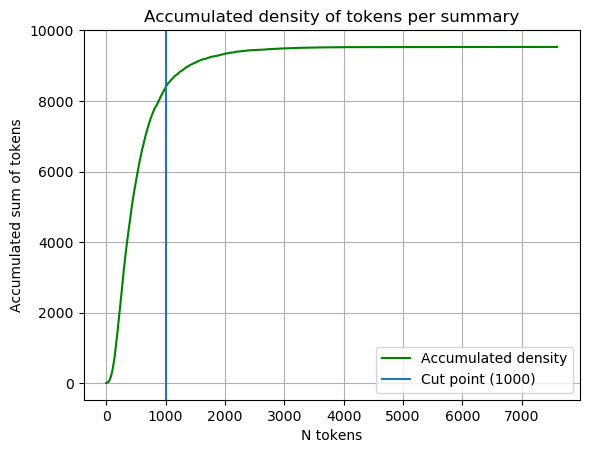

In [7]:
graph = summ
graph_str = 'summary'

acc_text = graph.groupby(graph_str).count().cumsum()
acc_text.plot(style='green')

plt.axvline(x=SUMMARY_N_TOKENS)
plt.title('Accumulated density of tokens per summary')
plt.xlabel('N tokens')
plt.ylabel('Accumulated sum of tokens')
plt.grid()
plt.legend(['Accumulated density', f'Cut point ({SUMMARY_N_TOKENS})'])

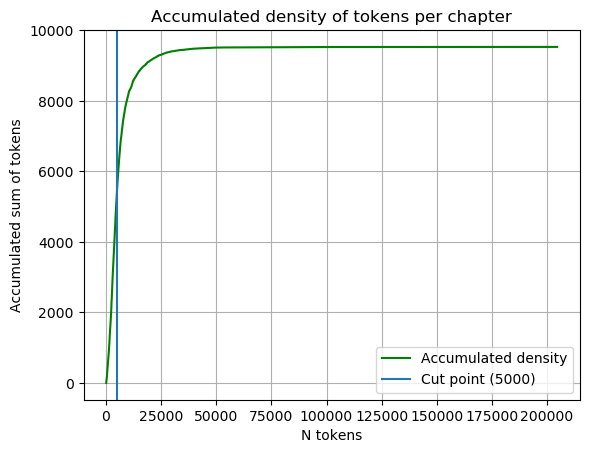

In [10]:
graph = text
graph_str = 'text'

acc_text = graph.groupby(graph_str).count().cumsum()
acc_text.plot(style='green')

plt.axvline(x=TEXT_N_TOKENS)
plt.title('Accumulated density of tokens per chapter')
plt.xlabel('N tokens')
plt.ylabel('Accumulated sum of tokens')
plt.grid()
plt.legend(['Accumulated density', f'Cut point ({TEXT_N_TOKENS})'])